In [ ]:
%pip install -q langchain langgraph langchain-docling langchain-qdrant langchain-text-splitters langchain-ollama

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from langchain_ollama import ChatOllama

reasoning_llm = ChatOllama(
    model="deepseek-r1:7b",
    stop=["</think>"]
)

answer_llm = ChatOllama(
    model="exaone3.5",
    temperature=0,
    )

In [3]:
from typing import Annotated, List, TypedDict, Literal
from langgraph.graph.message import add_messages
from langchain_core.documents import Document

# RAG 상태 정의
class RAGState(TypedDict):
    """RAG 시스템의 상태를 정의합니다."""
    query: str  # 사용자 질의
    thinking: str  # reasoning_llm이 생성한 사고 과정
    documents: List[Document]  # 검색된 문서
    answer: str  # 최종 답변
    messages: Annotated[List, add_messages]
    mode: str

In [5]:
from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType

FILE_PATH = "https://arxiv.org/pdf/2408.09869"

loader = DoclingLoader(
    file_path=FILE_PATH,
    export_type=ExportType.MARKDOWN
    )

docs = loader.load()

Error while downloading from https://cdn-lfs-us-1.hf.co/repos/84/16/8416a7eb6bc0964a8abb5bb890afca2b8384fdc1e010a788e6c411a97c4d2305/3119563aab5a7c96fda4d621119b63fd8806272b86c30936d15507616422f718?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27tableformer_fast.safetensors%3B+filename%3D%22tableformer_fast.safetensors%22%3B&Expires=1748435094&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0ODQzNTA5NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzg0LzE2Lzg0MTZhN2ViNmJjMDk2NGE4YWJiNWJiODkwYWZjYTJiODM4NGZkYzFlMDEwYTc4OGU2YzQxMWE5N2M0ZDIzMDUvMzExOTU2M2FhYjVhN2M5NmZkYTRkNjIxMTE5YjYzZmQ4ODA2MjcyYjg2YzMwOTM2ZDE1NTA3NjE2NDIyZjcxOD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=UyjAuzsAZtZ6749wp8QBQepAbpP%7EY2XzpX4mIbboRIojY4kYfNLuD0UktnY14T1k95vzr5oiyzeXpSAY1EuKdIaos9NAVwCeuoMkELjvPxYIMtBSXfktT4uANfP5%7E%7E%7EI542VS27DAxQVsx1vcJVd-mGKhyMW9AK9Jvo9Ila8APUscVFu-uW6FWsOo1hSUgB7BogXKyWbENwnvxMV1h0ZB2Q7q9j2g4b-YRVMot

In [6]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=[
        ("#", "Header_1"),
        ("##", "Header_2"),
        ("###", "Header_3"),
    ],
)
splits = [split for doc in docs for split in splitter.split_text(doc.page_content)]

for d in splits[:3]:
    print(f"- {d.page_content=}")
print("...")

- d.page_content='Version 1.0  \nChristoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J. Staar  \nAI4K Group, IBM Research R¨ uschlikon, Switzerland'
- d.page_content='This technical report introduces Docling , an easy to use, self-contained, MITlicensed open-source package for PDF document conversion. It is powered by state-of-the-art specialized AI models for layout analysis (DocLayNet) and table structure recognition (TableFormer), and runs efficiently on commodity hardware in a small resource budget. The code interface allows for easy extensibility and addition of new features and models.'
- d.page_content='Converting PDF documents back into a machine-processable format has been a major challenge for decades due to their huge variability in formats, we

In [7]:
from IPython.display import Markdown

display(Markdown(splits[12].page_content))

In this section, we establish some reference numbers for the processing speed of Docling and the resource budget it requires. All tests in this section are run with default options on our standard test set distributed with Docling, which consists of three papers from arXiv and two IBM Redbooks, with a total of 225 pages. Measurements were taken using both available PDF backends on two different hardware systems: one MacBook Pro M3 Max, and one bare-metal server running Ubuntu 20.04 LTS on an Intel Xeon E5-2690 CPU. For reproducibility, we fixed the thread budget (through setting OMP NUM THREADS environment variable ) once to 4 (Docling default) and once to 16 (equal to full core count on the test hardware). All results are shown in Table 1.  
If you need to run Docling in very low-resource environments, please consider configuring the pypdfium backend. While it is faster and more memory efficient than the default docling-parse backend, it will come at the expense of worse quality results, especially in table structure recovery.  
Establishing GPU acceleration support for the AI models is currently work-in-progress and largely untested, but may work implicitly when CUDA is available and discovered by the onnxruntime and  
torch runtimes backing the Docling pipeline. We will deliver updates on this topic at in a future version of this report.  
Table 1: Runtime characteristics of Docling with the standard model pipeline and settings, on our test dataset of 225 pages, on two different systems. OCR is disabled. We show the time-to-solution (TTS), computed throughput in pages per second, and the peak memory used (resident set size) for both the Docling-native PDF backend and for the pypdfium backend, using 4 and 16 threads.  
| CPU                         | Thread budget   | native backend   | native backend   | native backend   | pypdfium backend   | pypdfium backend   | pypdfium backend   |
|-----------------------------|-----------------|------------------|------------------|------------------|--------------------|--------------------|--------------------|
|                             |                 | TTS              | Pages/s          | Mem              | TTS                | Pages/s            | Mem                |
| Apple M3 Max                | 4               | 177 s 167 s      | 1.27 1.34        | 6.20 GB          | 103 s 92 s         | 2.18 2.45          | 2.56 GB            |
| (16 cores) Intel(R) E5-2690 | 16 4 16         | 375 s 244 s      | 0.60 0.92        | 6.16 GB          | 239 s 143 s        | 0.94 1.57          | 2.42 GB            |

In [8]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model="bge-m3:latest",
)

In [9]:
from langchain_qdrant import QdrantVectorStore
from langchain_qdrant import RetrievalMode

vector_store = QdrantVectorStore.from_documents(
    documents=splits,
    embedding=embeddings,
    location=":memory:",
    collection_name="rag_collection_0228",
    retrieval_mode=RetrievalMode.DENSE
)

retriever = vector_store.as_retriever(search_kwargs = {'k':10})

In [11]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")

compressor = CrossEncoderReranker(model=model, top_n=5)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [12]:
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, StateGraph, END

# 1. 질문 분류 함수 - 중요: 여기서는 상태를 업데이트하는 노드 함수
def classify_node(state: RAGState):
    """질문을 분류하여 처리 모드를 결정합니다."""
    query = state["query"]

    if "Docling" in query:
        print("=====검색 시작=====")
        return {"mode": "retrieve"}
    else:
        print("=====생성 시작=====")
        return {"mode": "generate"}


# 2. 라우팅 함수 - 중요: 이 함수는 조건부 엣지에서 사용하며 문자열 반환
def route_by_mode(state: RAGState) -> Literal["retrieve", "generate"]:
    """모드에 따라 다음 단계를 결정합니다."""
    return state["mode"]







def retrieve(state: RAGState):
    """질의를 기반으로 관련 문서를 검색합니다."""
    query = state["query"]
    print("=====검색 시작=====")
    documents = compression_retriever.invoke(query)
    for doc in documents:
        print(doc.page_content)
        print("-"*100)
    print("=====검색 완료=====")
    return {"documents": documents}







def reasoning(state: RAGState):
    """쿼리를 분석하여 사고 과정을 생성합니다."""
    query = state["query"]
    documents = state["documents"]

    context = "\n\n".join([doc.page_content for doc in documents])

    reasoning_prompt = ChatPromptTemplate.from_template(
        """주어진 문서를 활용하여 사용자의 질문에 가장 적절한 답변을 작성해주세요.

        질문: {query}

        문서 내용:
        {context}


        상세 추론:"""
    )

    reasoning_chain = reasoning_prompt | reasoning_llm | StrOutputParser()

    print("=====추론 시작=====")
    thinking = reasoning_chain.invoke({"query": query, "context": context})

    return {"thinking": thinking}



# 3. 답변 생성 노드 (Answer LLM)
def generate(state: RAGState):
    """문서와 추론 과정을 기반으로 최종 답변을 생성합니다."""

    query = state["query"]
    thinking = state.get("thinking", "")  # get 메서드로 안전하게 접근
    documents = state.get("documents", [])  # get 메서드로 안전하게 접근

    # 문서 내용 추출
    context = "\n\n".join([doc.page_content for doc in documents])

    # 최종 답변 생성을 위한 프롬프트
    answer_prompt = ChatPromptTemplate.from_template(
        """사용자 질문에 한글로 답변하세요. 제공된 문서와 추론 과정이 있다면, 최대한 활용하세요.

        질문:
        {query}

        추론 과정:
        {thinking}

        문서 내용:
        {context}

        답변:"""
    )
    print("=====답변 생성 시작=====")

    answer_chain = answer_prompt | answer_llm | StrOutputParser()

    answer = answer_chain.invoke({
        "query": query,
        "thinking": thinking,
        "context": context
    })
    print("=====답변 생성 완료=====")
    # 메시지에 답변 추가
    return {
        "answer": answer,
        "messages": [HumanMessage(content=answer)]
    }

In [13]:
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(RAGState)

# 노드 추가
workflow.add_node("classify", classify_node)
workflow.add_node("reasoning", reasoning)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)

# 엣지 추가
workflow.add_edge(START, "classify")
workflow.add_conditional_edges(
    "classify",
    route_by_mode,  # 이 함수는 state["mode"] 값을 반환
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)
workflow.add_edge("retrieve", "reasoning")
workflow.add_edge("reasoning", "generate")

workflow.add_edge("generate", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

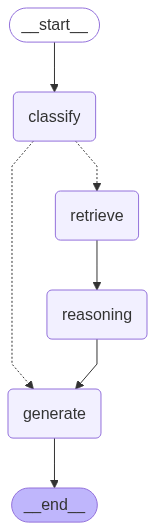

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
input={"query":"Docling이 다른 라이브러리와 다른 점이 무엇인지 설명해줘"}
config={"configurable": {"thread_id": 0}}

async for event in app.astream_events(
    input=input, stream_mode="events", version="v2",config=config
    ):

    kind = event["event"]

    if kind == "on_chat_model_stream":
        chunk = event["data"]["chunk"].content
        print(chunk, end="", flush=True)

    elif kind == "on_retriever_end ":
        print(event)

    elif kind == "on_chat_model_end":
        print("\n\n")

=====검색 시작=====
=====검색 시작=====
Docling implements a linear pipeline of operations, which execute sequentially on each given document (see Fig. 1). Each document is first parsed by a PDF backend, which retrieves the programmatic text tokens, consisting of string content and its coordinates on the page, and also renders a bitmap image of each page to support downstream operations. Then, the standard model pipeline applies a sequence of AI models independently on every page in the document to extract features and content, such as layout and table structures. Finally, the results from all pages are aggregated and passed through a post-processing stage, which augments metadata, detects the document language, infers reading-order and eventually assembles a typed document object which can be serialized to JSON or Markdown.
----------------------------------------------------------------------------------------------------
Docling provides a straight-forward interface to extend its capabiliti

In [16]:
snap=app.get_state(config)
snap.values['documents']

KeyError: 'documents'

In [17]:
snap

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '0'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())